## Imports
Execute the cell below to import all packages needed.

In [1]:
# System functionality
import sys
sys.path.append('..')

import glob
import os
import numpy as np 
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import seaborn as sns
import graphviz
import math as math
import json
import cv2
import matplotlib.image as mpimg
import sklearn.feature_selection
from skimage import data, io, filters
from numpy import linspace
from numpy.core.umath import pi
from matplotlib.ticker import FuncFormatter
from matplotlib.font_manager import FontProperties
from emoji_extractor.extract import Extractor
from emojipedia import Emojipedia
from skimage import io

## Load csv into pandas dataframe

In [2]:
path__tweets_csv = '/home/stelios/Desktop/Honours Project/Samples/tweet_data/tweets_nyc_all.csv'
path_users_csv = '/home/stelios/Desktop/Honours Project/Samples/user_data/nyc.csv'

nyc_tweets_df = pd.read_csv(path__tweets_csv,index_col=None, header=0, low_memory = False).applymap(str)
nyc_users_df = pd.read_csv(path_users_csv,index_col=None, header=0, low_memory = False).applymap(str)

nyc_join_df = nyc_tweets_df.join(nyc_users_df.set_index('user_id'), on='user_id')

## Bar Chart Formatters

In [3]:
# Millions Formatter Function
def millions(x,pos):
    return '%1.1fK' % (x*1e-3)

# Power of 10 Formatter Function (y log scale bug, so i have created this formatter)
def pow10(x,pos):
    return "{:.0f}\n10 ".format(x)

# Power of 10 (1 d.p) Formatter Function (y log scale bug, so i have created this formatter)
def pow10_1dp(x,pos):
    return "{:.1f}\n10     ".format(x)

# Percenatge Formatter Function
def percentage(x,pos):
    return "{:.1f}%".format(x*100)

# Create a formatters
formatter_millions = FuncFormatter(millions)
formatter_pow10 = FuncFormatter(pow10)
formatter_pow10_1dp = FuncFormatter(pow10_1dp)
formatter_percentage = FuncFormatter(percentage)

# Use TwitterColorEmoji Font (only one supporting emojis) 
emojis_font = FontProperties(fname='./Fonts/TwitterColorEmoji-SVGinOT.ttf',size=55)

## Colours

In [4]:
colors_seagreen_fade=["#f3f8f3","#e8f1e8","#ddeadd","#d2e4d2","#c7ddc7","#bbd6bb","#b0d0b0","#a5c9a5","#9ac29a","#8fbc8f","#80a980","#729672","#648364","#557055","#475e47","#394b39"]

colors_orange_fade=["#fff6e5","#ffedcc","#ffe4b2","#ffdb99","#ffd27f","#ffc966","#ffc04c","#ffb732","#ffae19","#ffa500","#e59400","#cc8400","#b27300","#996300","#7f5200","#664200"]

colors_dodgeblue_fade=["#e7f1fa","#d0e3f5","#b9d5f0","#a2c7eb","#8bb9e6","#74abe1","#5d9ddc","#468fd7","#2f81d2","#1874cd","#1568b8","#135ca4","#10518f","#0e457b","#0c3a66","#092e52"]

colors_indianred_fade=["#faeeee","#f5dddd","#f0cccc","#ebbbbb","#e6aaaa","#e19999","#dc8888","#d77676","#d26666","#cd5555","#b84c4c","#a44444","#8f3b3b","#7b3333","#662a2a","#522222"]

## Emojis on Pie Chart Function

In [5]:
def pie_chart_plot_emojis(ax,fig,x):
    # Set sizes of figure and images
    ax_width = ax.get_window_extent().width
    fig_width = fig.get_window_extent().width
    fig_height = fig.get_window_extent().height
    img_size = ax_width/(fig_width*len(x_linespace))
    img_axs = [None for i in range(len(x_linespace))]

    y_manual = 0.843
    loc = ax.transData.transform((1.88, y_manual))
    img_axs[0] = fig.add_axes([loc[0]/fig_width-img_size/2, loc[1]/fig_height-img_size/2, img_size, img_size], anchor='C')
    img_axs[0].imshow(io.imread("/home/stelios/Desktop/Honours Project/Emojis-usage-in-social-media-by-demographics/Jupyter/Fonts&Pics/other_less.png"))
    img_axs[0].axis("off")
    y_manual =y_manual-0.1408

    # Display emojis pngs on x-axis
    for i in range(len(x)):
        loc = ax.transData.transform((1.88, y_manual))      # Optimize y manually 
        img_axs[i] = fig.add_axes([loc[0]/fig_width-img_size/2, loc[1]/fig_height-img_size/2, img_size, img_size], anchor='C')
        y_manual =y_manual-0.1408
        # Platform 5 = Twitter
        img_axs[i].imshow(io.imread(Emojipedia.search(x[i]).platforms[5].image_url))
        img_axs[i].axis("off")

## Emojis on Bar Chart Function

In [6]:
def bar_chart_plot_emojis(ax,fig,x):
    # Set sizes of figure and images
    ax_width = ax.get_window_extent().width
    fig_width = fig.get_window_extent().width
    fig_height = fig.get_window_extent().height
    img_size = ax_width/(fig_width*len(x_linespace))
    img_axs = [None for i in range(len(x_linespace))]

    # Display emojis pngs on x-axis
    for i in range(len(x)):
        loc = ax.transData.transform((x_linespace[i], 0))      # Optimize y manually 
        img_axs[i] = fig.add_axes([loc[0]/fig_width-img_size/2, loc[1]/fig_height-img_size/2,
                                   img_size, img_size], anchor='C')

        # Platform 5 = Twitter
        img_axs[i].imshow(io.imread(Emojipedia.search(x[i]).platforms[5].image_url))
        img_axs[i].axis("off")

## Extract, Count & Sort Emojis for all

In [7]:
extract = Extractor()

count = extract.count_all_emoji(nyc_join_df['text'])

# Display most common
#count.most_common()

# Create panda dataframe to store emojis with counts
emojis_count_df = pd.DataFrame(columns = ['Emoji','Count'])
for emoji in count:
    emojis_count_df = emojis_count_df.append({'Emoji' : emoji , 'Count' : count[emoji]} , ignore_index=True)

# Sort dataframe by count
emojis_count_df = emojis_count_df.sort_values(by=['Count'])
emojis_count_df.tail(20)

,Emoji,Count
237,👏,5897
33,💙,5937
172,💖,6945
197,💀,7001
12,😘,7178
171,💜,7282
150,💯,8167
161,✨,9011
113,🙄,9987
100,💕,10192


## Top 15 Emojis Graph

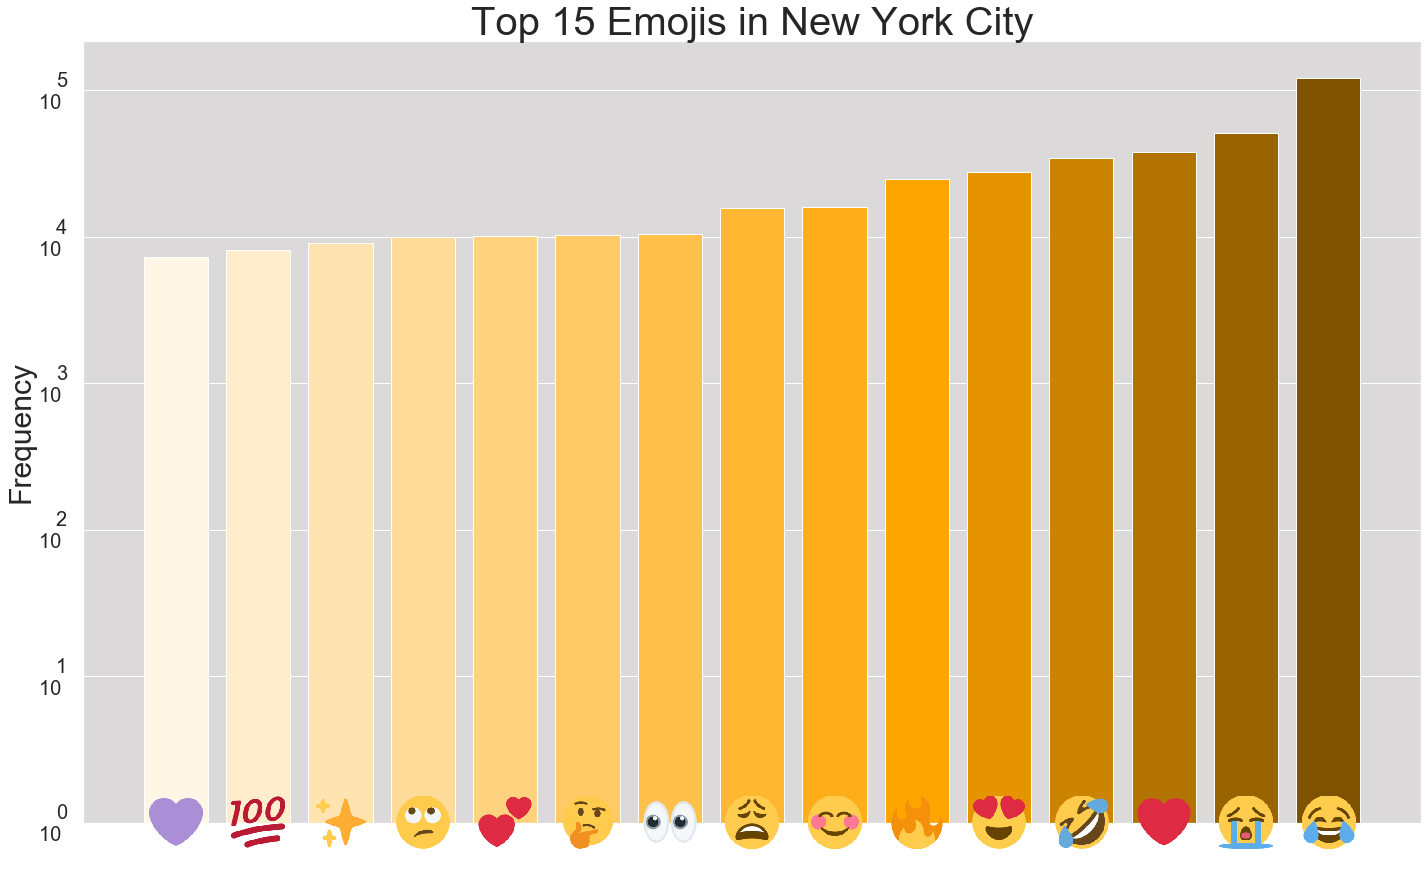

In [8]:
# Top 15 Values
x = emojis_count_df['Emoji'].tail(15).values
y = emojis_count_df['Count'].tail(15).values
y_log = np.log10(y.astype(int))

# Set linespacing
x_linespace = linspace(0, 4*pi, num=15)

# Plot Bar Chart
sns.set(color_codes=True) # Seaborn 
fig, ax = plt.subplots(figsize=(20,12))
ax.yaxis.set_major_formatter(formatter_pow10)
ax.tick_params(axis='both', which='major', pad=10)
ax.set_facecolor('#dbd9d9')
plt.grid(linestyle='-', linewidth=1,axis='y')
plt.bar(x_linespace, y_log, width=0.7, bottom=None, align='center',color =colors_orange_fade)
ax.get_xaxis().set_visible(False)
plt.yticks(fontsize =20)
plt.ylabel('Frequency', fontsize =30)
plt.title('Top 15 Emojis in New York City', fontsize =40)
plt.tight_layout()

# Plot emojis on x-axis
bar_chart_plot_emojis(ax,fig,x)
plt.show()

## Extract, Count & Sort Emojis for females

In [9]:
# Count emojis (Gender Confidence =1)
count_females = extract.count_all_emoji(nyc_join_df.loc[(nyc_join_df['gender'] == 'female')& (nyc_join_df['gender:confidence'].astype(float)==1)]['text'])

# Create panda dataframe to store emojis with counts
emojis_count_females_df = pd.DataFrame(columns = ['Emoji','Count'])
for emoji in count_females:
    emojis_count_females_df = emojis_count_females_df.append({'Emoji' : emoji , 'Count' : count_females[emoji]} , ignore_index=True)

# Sort dataframe by count
emojis_count_females_df = emojis_count_females_df.sort_values(by=['Count'])
emojis_count_females_df.tail(20)

,Emoji,Count
21,💛,2072
95,💯,2091
136,♥,2117
108,💜,2243
110,💖,2259
137,👀,2385
73,🤔,2464
186,💀,2580
153,😊,2725
106,✨,2994


## Extract, Count & Sort Emojis for males

In [10]:
# Count emojis (Gender Confidence =1)
count_males = extract.count_all_emoji(nyc_join_df.loc[(nyc_join_df['gender'] == 'male')& (nyc_join_df['gender:confidence'].astype(float)==1)]['text'])

# Create panda dataframe to store emojis with counts
emojis_count_males_df = pd.DataFrame(columns = ['Emoji','Count'])
for emoji in count_males:
    emojis_count_males_df = emojis_count_males_df.append({'Emoji' : emoji , 'Count' : count_males[emoji]} , ignore_index=True)

# Sort dataframe by count
emojis_count_males_df = emojis_count_males_df.sort_values(by=['Count'])
emojis_count_males_df.tail(20)

,Emoji,Count
19,🙏,1247
55,💪🏾,1270
138,👏,1334
155,😎,1410
68,🗣,1447
40,🙄,1491
56,💀,1600
39,😁,1659
287,💯,1769
327,🖤,2022


## Dinstict Emojis per Gender

In [11]:
gender_stats_df = emojis_count_females_df.rename(columns={'Count': 'Females_Count'}).join(emojis_count_males_df.rename(columns={'Count': 'Males_Count'}).set_index('Emoji'), on='Emoji')

# Calculate percentage usage for each emoji per gender
female_count_perc = gender_stats_df['Females_Count'] /gender_stats_df['Females_Count'].sum()
gender_stats_df['Females_Count_Perc']=female_count_perc
male_count_perc = gender_stats_df['Males_Count'] /gender_stats_df['Males_Count'].sum()
gender_stats_df['Males_Count_Perc']=male_count_perc
male_perc_dif = gender_stats_df['Males_Count_Perc'] - gender_stats_df['Females_Count_Perc']
gender_stats_df['Males_Perc_Dif']=male_perc_dif
female_perc_dif = gender_stats_df['Females_Count_Perc'] - gender_stats_df['Males_Count_Perc']
gender_stats_df['Females_Perc_Dif']=female_perc_dif

gender_stats_df.tail(20)

,Emoji,Females_Count,Males_Count,Females_Count_Perc,Males_Count_Perc,Males_Perc_Dif,Females_Perc_Dif
21,💛,2072,311,0.00759152,0.00159682,-0.0059947,0.0059947
95,💯,2091,1769,0.00766114,0.00908288,0.00142174,-0.00142174
136,♥,2117,727,0.0077564,0.00373276,-0.00402364,0.00402364
108,💜,2243,502,0.00821804,0.0025775,-0.00564054,0.00564054
110,💖,2259,705,0.00827667,0.0036198,-0.00465686,0.00465686
137,👀,2385,2503,0.00873831,0.0128516,0.00411327,-0.00411327
73,🤔,2464,2780,0.00902776,0.0142738,0.00524607,-0.00524607
186,💀,2580,1600,0.00945277,0.00821515,-0.00123761,0.00123761
153,😊,2725,955,0.00998403,0.00490342,-0.0050806,0.0050806
106,✨,2994,1058,0.0109696,0.00543227,-0.00553733,0.00553733


## Top 15 Emojis Graph by Gender

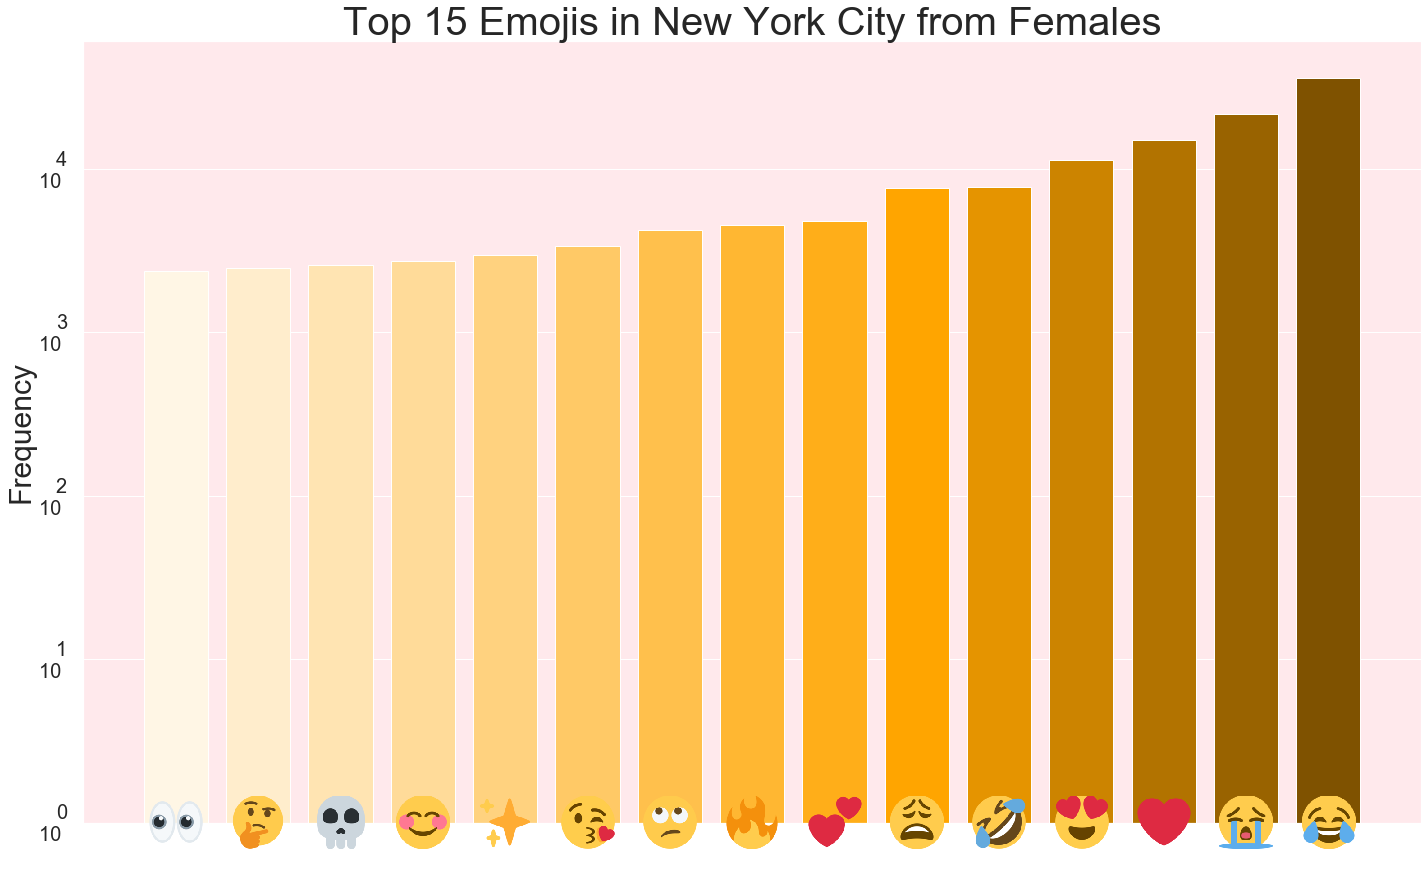

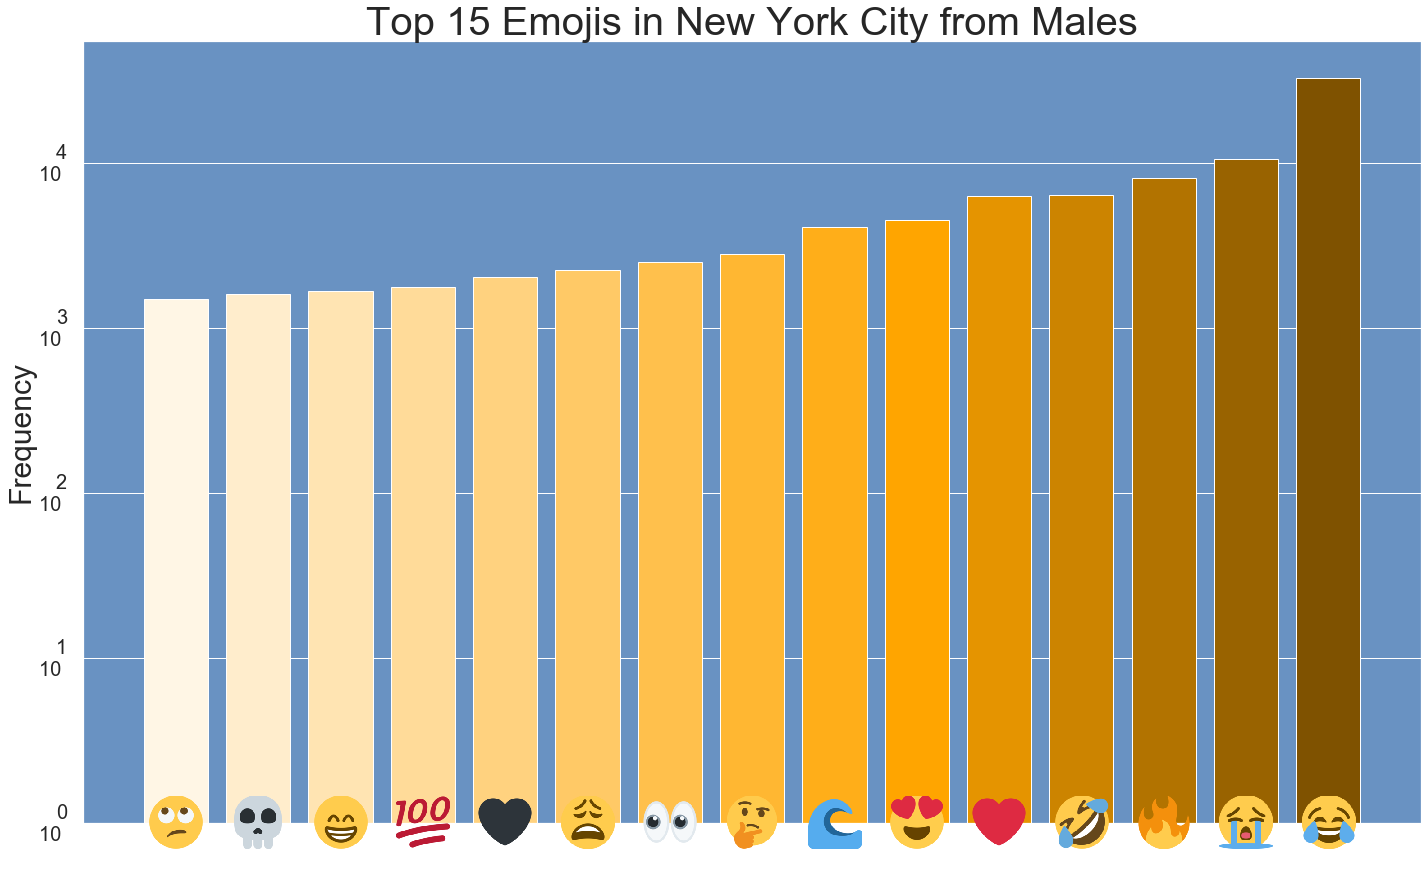

In [12]:
gender_list = ['Females','Males']
gender_values =[emojis_count_females_df,emojis_count_males_df]
gender_graph_colours=['ffe9ec','6992C2']

for ind,gen in enumerate(gender_list):
    
    # Top 15 Values
    x = gender_values[ind]['Emoji'].tail(15).values
    y = gender_values[ind]['Count'].tail(15).values
    y_log = np.log10(y.astype(int))

    # Set linespacing
    x_linespace = linspace(0, 4*pi, num=15)

    # Plot Bar Chart
    fig, ax = plt.subplots(figsize=(20,12))
    ax.yaxis.set_major_formatter(formatter_pow10)
    ax.tick_params(axis='both', which='major', pad=10)
    ax.set_facecolor('#{}'.format(gender_graph_colours[ind]))
    plt.grid(linestyle='-', linewidth=1,axis='y')
    plt.bar(x_linespace, y_log, width=0.7, bottom=None, align='center',color =colors_orange_fade)
    ax.get_xaxis().set_visible(False)
    #plt.xticks(x, fontproperties=emojis_font)  Old method
    plt.yticks(fontsize =20)
    plt.ylabel('Frequency', fontsize =30)
    plt.title('Top 15 Emojis in New York City from {}'.format(gender_list[ind]), fontsize =40)
    plt.tight_layout()

    # Plot emojis on x-axis
    bar_chart_plot_emojis(ax,fig,x)
    plt.show()

## Top 15 Dinstinct Emojis by Gender

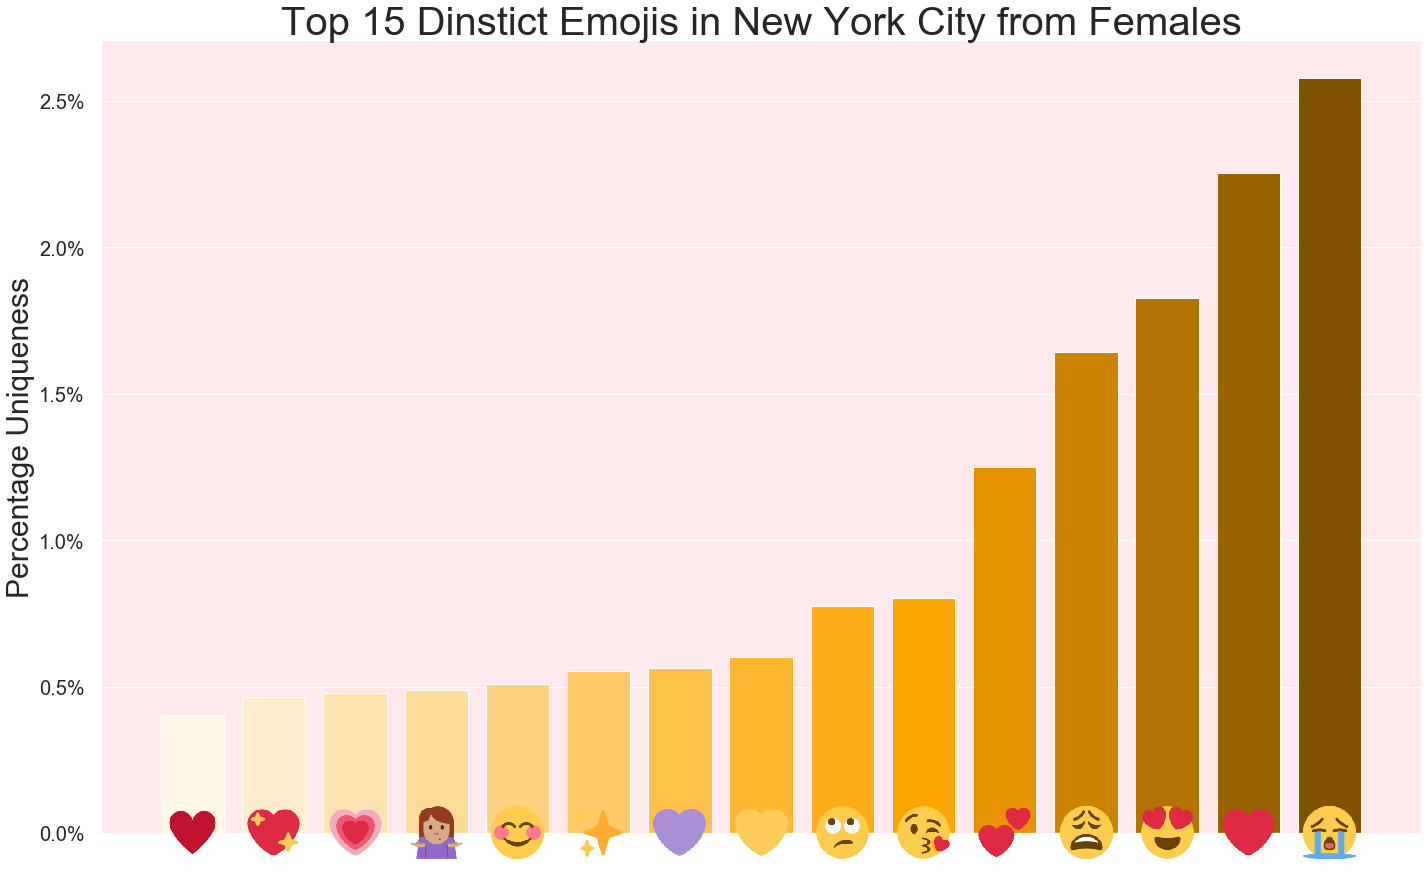

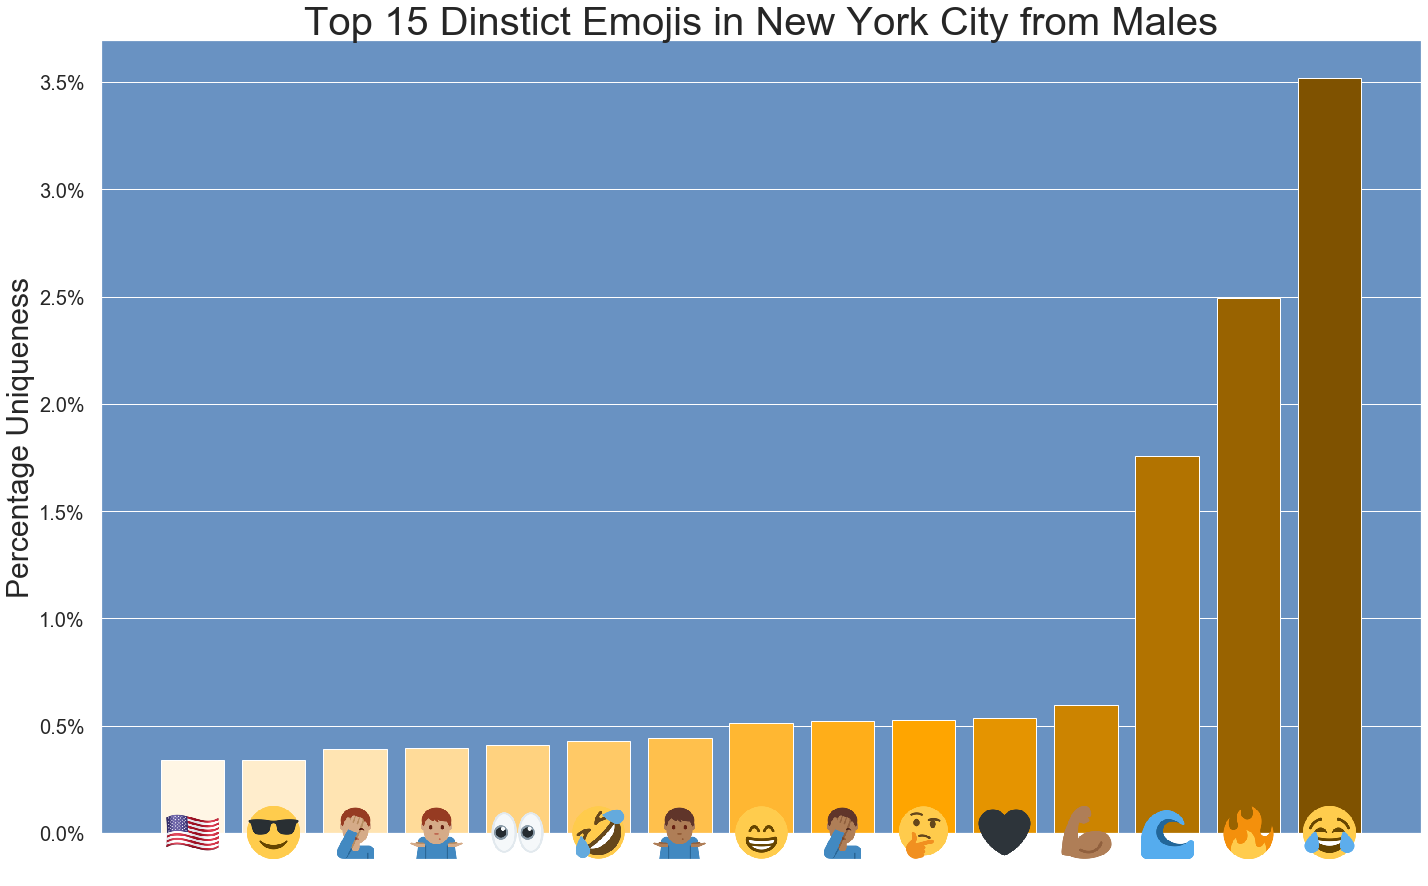

In [13]:
gender_list = ['Females','Males']
gender_values =[gender_stats_df.fillna(0).sort_values(by=['Females_Perc_Dif']),gender_stats_df.fillna(0).sort_values(by=['Males_Perc_Dif'])]
gender_graph_colours=['ffe9ec','6992C2']

for ind,gen in enumerate(gender_list):
    
    # Top 15 Values
    x = gender_values[ind]['Emoji'].tail(15).values
    y = gender_values[ind]['{}_Perc_Dif'.format(gender_list[ind])].tail(15).values
    
    # Set linespacing
    x_linespace = linspace(0, 4*pi, num=15)

    # Plot Bar Chart
    fig, ax = plt.subplots(figsize=(20,12))
    ax.yaxis.set_major_formatter(formatter_percentage)
    ax.tick_params(axis='both', which='major', pad=10)
    ax.set_facecolor('#{}'.format(gender_graph_colours[ind]))
    plt.grid(linestyle='-', linewidth=1,axis='y')
    plt.bar(x_linespace, y, width=0.7, bottom=None, align='center',color =colors_orange_fade)
    ax.get_xaxis().set_visible(False)
    #plt.xticks(x, fontproperties=emojis_font)  Old method
    plt.yticks(fontsize =20)
    plt.ylabel('Percentage Uniqueness', fontsize =30)
    plt.title('Top 15 Dinstict Emojis in New York City from {}'.format(gender_list[ind]), fontsize =40)
    plt.tight_layout()

    # Plot emojis on x-axis
    bar_chart_plot_emojis(ax,fig,x)

    plt.show()

## Extract, Count & Sort Emojis for White Ethnicity

In [14]:
# Count emojis (Ethnicity Confidence: 0.75)
count_white = extract.count_all_emoji(nyc_join_df.loc[(nyc_join_df['ethnicity'] == 'white')& (nyc_join_df['ethnicity:confidence'].astype(float)>0.75)]['text'])
count_not_white =extract.count_all_emoji(nyc_join_df.loc[(nyc_join_df['ethnicity'] != 'white')& (nyc_join_df['ethnicity:confidence'].astype(float)>0.75)]['text'])

# Create panda dataframe to store emojis with counts

# Whites
emojis_count_white_df = pd.DataFrame(columns = ['Emoji','Whites_Count'])
for emoji in count_white:
    emojis_count_white_df = emojis_count_white_df.append({'Emoji' : emoji , 'Whites_Count' : count_white[emoji]} , ignore_index=True)

# Not Whites
emojis_count_not_white_df = pd.DataFrame(columns = ['Emoji','Not_Whites_Count'])
for emoji in count_not_white:
    emojis_count_not_white_df = emojis_count_not_white_df.append({'Emoji' : emoji , 'Not_Whites_Count' : count_not_white[emoji]} , ignore_index=True)    

# White Stats
white_stats_df = emojis_count_white_df.join(emojis_count_not_white_df.set_index('Emoji'), on='Emoji')

# Calculate percentage usage for each emoji per ethnicity
white_count_perc = white_stats_df['Whites_Count'] /white_stats_df['Whites_Count'].sum()
white_stats_df['Whites_Count_Perc']=white_count_perc
not_white_count_perc = white_stats_df['Not_Whites_Count'] /white_stats_df['Not_Whites_Count'].sum()
white_stats_df['Not_Whites_Count_Perc']=not_white_count_perc
white_perc_dif = white_stats_df['Whites_Count_Perc'] - white_stats_df['Not_Whites_Count_Perc']
white_stats_df['Whites_Perc_Dif']=white_perc_dif
not_white_perc_dif = white_stats_df['Not_Whites_Count_Perc'] - white_stats_df['Whites_Count_Perc']
white_stats_df['Not_Whites_Perc_Dif']=not_white_perc_dif

white_stats_df = white_stats_df.fillna(0).sort_values(by=['Whites_Perc_Dif'])
white_stats_df.tail(20)

,Emoji,Whites_Count,Not_Whites_Count,Whites_Count_Perc,Not_Whites_Count_Perc,Whites_Perc_Dif,Not_Whites_Perc_Dif
132,🙌,977,453,0.005248,0.001989,0.003259,-0.003259
94,😉,1207,723,0.006484,0.003175,0.003309,-0.003309
46,💚,971,386,0.005216,0.001695,0.003521,-0.003521
73,😘,2119,1778,0.011383,0.007808,0.003575,-0.003575
446,🙌🏼,920,174,0.004942,0.000764,0.004178,-0.004178
35,💜,1748,1133,0.009390,0.004975,0.004415,-0.004415
310,🙌🏻,840,19,0.004512,0.000083,0.004429,-0.004429
17,🙏,1564,851,0.008402,0.003737,0.004665,-0.004665
123,🙏🏻,943,21,0.005066,0.000092,0.004973,-0.004973
42,✨,2088,1361,0.011216,0.005977,0.005240,-0.005240


## Extract, Count & Sort Emojis for Black Ethnicity

In [15]:
# Count emojis (Ethnicity Confidence: 0.75)
count_black = extract.count_all_emoji(nyc_join_df.loc[(nyc_join_df['ethnicity'] == 'black')& (nyc_join_df['ethnicity:confidence'].astype(float)>0.75)]['text'])
count_not_black  =extract.count_all_emoji(nyc_join_df.loc[(nyc_join_df['ethnicity'] != 'black')& (nyc_join_df['ethnicity:confidence'].astype(float)>0.75)]['text'])

# Create panda dataframe to store emojis with counts

# Blacks 
emojis_count_black_df = pd.DataFrame(columns = ['Emoji','Blacks_Count'])
for emoji in count_black:
    emojis_count_black_df = emojis_count_black_df.append({'Emoji' : emoji , 'Blacks_Count' : count_black[emoji]} , ignore_index=True)

# Not Blacks
emojis_count_not_black_df = pd.DataFrame(columns = ['Emoji','Not_Blacks_Count'])
for emoji in count_not_black:
    emojis_count_not_black_df = emojis_count_not_black_df.append({'Emoji' : emoji , 'Not_Blacks_Count' : count_not_black[emoji]} , ignore_index=True)    

# Black Stats
black_stats_df = emojis_count_black_df.join(emojis_count_not_black_df.set_index('Emoji'), on='Emoji')

# Calculate percentage usage for each emoji per ethnicity
black_count_perc = black_stats_df['Blacks_Count'] /black_stats_df['Blacks_Count'].sum()
black_stats_df['Blacks_Count_Perc']=black_count_perc
not_black_count_perc = black_stats_df['Not_Blacks_Count'] /black_stats_df['Not_Blacks_Count'].sum()
black_stats_df['Not_Blacks_Count_Perc']=not_black_count_perc
black_perc_dif = black_stats_df['Blacks_Count_Perc'] - black_stats_df['Not_Blacks_Count_Perc']
black_stats_df['Blacks_Perc_Dif']=black_perc_dif
not_black_perc_dif = black_stats_df['Not_Blacks_Count_Perc'] - black_stats_df['Blacks_Count_Perc']
black_stats_df['Not_Blacks_Perc_Dif']=not_black_perc_dif

black_stats_df = black_stats_df.fillna(0).sort_values(by=['Blacks_Perc_Dif'])
black_stats_df.tail(20)

,Emoji,Blacks_Count,Not_Blacks_Count,Blacks_Count_Perc,Not_Blacks_Count_Perc,Blacks_Perc_Dif,Not_Blacks_Perc_Dif
141,‼,1439,537,0.006572,0.002747,0.003825,-0.003825
113,🤷🏾‍♀️,877,14,0.004005,0.000072,0.003934,-0.003934
99,🤷🏾‍♂️,921,28,0.004206,0.000143,0.004063,-0.004063
118,👏🏾,1064,81,0.004860,0.000414,0.004445,-0.004445
20,🙄,3088,1854,0.014104,0.009485,0.004619,-0.004619
45,🤦🏾‍♂️,1026,13,0.004686,0.000067,0.004620,-0.004620
412,📹,1086,27,0.004960,0.000138,0.004822,-0.004822
88,🤦🏾‍♀️,1097,2,0.005010,0.000010,0.005000,-0.005000
0,🗣,2026,514,0.009253,0.002630,0.006624,-0.006624
8,🙌🏾,1558,59,0.007116,0.000302,0.006814,-0.006814


## Extract, Count & Sort Emojis for Other and Hispanic Ethnicity

In [16]:
# Count emojis (Ethnicity Confidence: 0.75)
count_other = extract.count_all_emoji(nyc_join_df.loc[((nyc_join_df['ethnicity'] == 'hispanic')|(nyc_join_df['ethnicity'] == 'other'))& (nyc_join_df['ethnicity:confidence'].astype(float)>0.75)]['text'])
count_not_other  =extract.count_all_emoji(nyc_join_df.loc[(nyc_join_df['ethnicity'] != 'hispanic')&(nyc_join_df['ethnicity'] != 'other')& (nyc_join_df['ethnicity:confidence'].astype(float)>0.75)]['text'])

# Create panda dataframe to store emojis with counts

# Others 
emojis_count_other_df = pd.DataFrame(columns = ['Emoji','Others_Count'])
for emoji in count_other:
    emojis_count_other_df = emojis_count_other_df.append({'Emoji' : emoji , 'Others_Count' : count_other[emoji]} , ignore_index=True)

# Not Others
emojis_count_not_other_df = pd.DataFrame(columns = ['Emoji','Not_Others_Count'])
for emoji in count_not_other:
    emojis_count_not_other_df = emojis_count_not_other_df.append({'Emoji' : emoji , 'Not_Others_Count' : count_not_other[emoji]} , ignore_index=True)    

# Others Stats
other_stats_df = emojis_count_other_df.join(emojis_count_not_other_df.set_index('Emoji'), on='Emoji')

# Calculate percentage usage for each emoji per ethnicity
other_count_perc = other_stats_df['Others_Count'] /other_stats_df['Others_Count'].sum()
other_stats_df['Others_Count_Perc']=other_count_perc
not_other_count_perc = other_stats_df['Not_Others_Count'] /other_stats_df['Not_Others_Count'].sum()
other_stats_df['Not_Others_Count_Perc']=not_other_count_perc
other_perc_dif = other_stats_df['Others_Count_Perc'] - other_stats_df['Not_Others_Count_Perc']
other_stats_df['Others_Perc_Dif']=other_perc_dif
not_other_perc_dif = other_stats_df['Not_Others_Count_Perc'] - other_stats_df['Others_Count_Perc']
other_stats_df['Not_Others_Perc_Dif']=not_black_perc_dif

other_stats_df = other_stats_df.fillna(0).sort_values(by=['Others_Perc_Dif'])
other_stats_df.tail(20)

,Emoji,Others_Count,Not_Others_Count,Others_Count_Perc,Not_Others_Count_Perc,Others_Perc_Dif,Not_Others_Perc_Dif
215,🙌🏼,31,1063,0.007589,0.003129,0.004460,-0.000884
293,🖕🏾,20,144,0.004896,0.000424,0.004472,0.000053
95,💪,27,684,0.006610,0.002013,0.004596,0.000000
235,😉,43,1887,0.010526,0.005554,0.004972,-0.000035
165,😱,36,1270,0.008813,0.003738,0.005075,0.001032
306,👊,29,621,0.007099,0.001828,0.005271,0.000143
206,🤷🏻‍♀️,30,563,0.007344,0.001657,0.005687,0.001370
92,👇,30,554,0.007344,0.001631,0.005713,0.000588
305,⬇,27,290,0.006610,0.000854,0.005756,-0.000364
93,👎,27,186,0.006610,0.000547,0.006062,-0.000757


## Extract, Count & Sort Emojis for Asian Ethnicity

In [17]:
# Count emojis (Ethnicity Confidence: 0.75)
count_asian = extract.count_all_emoji(nyc_join_df.loc[(nyc_join_df['ethnicity'] == 'asian')& (nyc_join_df['ethnicity:confidence'].astype(float)>0.75)]['text'])
count_not_asian  =extract.count_all_emoji(nyc_join_df.loc[(nyc_join_df['ethnicity'] != 'asian')&(nyc_join_df['ethnicity:confidence'].astype(float)>0.75)]['text'])

# Create panda dataframe to store emojis with counts

# Asians 
emojis_count_asian_df = pd.DataFrame(columns = ['Emoji','Asians_Count'])
for emoji in count_asian:
    emojis_count_asian_df = emojis_count_asian_df.append({'Emoji' : emoji , 'Asians_Count' : count_asian[emoji]} , ignore_index=True)

# Not Asians
emojis_count_not_asian_df = pd.DataFrame(columns = ['Emoji','Not_Asians_Count'])
for emoji in count_not_asian:
    emojis_count_not_asian_df = emojis_count_not_asian_df.append({'Emoji' : emoji , 'Not_Asians_Count' : count_not_asian[emoji]} , ignore_index=True)    

# Asians Stats
asian_stats_df = emojis_count_asian_df.join(emojis_count_not_asian_df.set_index('Emoji'), on='Emoji')

# Calculate percentage usage for each emoji per gender
asian_count_perc = asian_stats_df['Asians_Count'] /asian_stats_df['Asians_Count'].sum()
asian_stats_df['Asians_Count_Perc']=asian_count_perc
not_asian_count_perc = asian_stats_df['Not_Asians_Count'] /asian_stats_df['Not_Asians_Count'].sum()
asian_stats_df['Not_Asians_Count_Perc']=not_asian_count_perc
asian_perc_dif = asian_stats_df['Asians_Count_Perc'] - asian_stats_df['Not_Asians_Count_Perc']
asian_stats_df['Asians_Perc_Dif']=asian_perc_dif
not_asian_perc_dif = asian_stats_df['Not_Asians_Count_Perc'] - asian_stats_df['Asians_Count_Perc']
asian_stats_df['Not_Asians_Perc_Dif']=not_black_perc_dif

asian_stats_df = asian_stats_df.fillna(0).sort_values(by=['Asians_Perc_Dif'])
asian_stats_df.tail(20)

,Emoji,Asians_Count,Not_Asians_Count,Asians_Count_Perc,Not_Asians_Count_Perc,Asians_Perc_Dif,Not_Asians_Perc_Dif
65,😱,61,1245,0.008018,0.003484,0.004534,0.002513
4,🤗,83,2142,0.010910,0.005995,0.004915,-0.016241
359,✊🏻,40,46,0.005258,0.000129,0.005129,0.000054
256,🌻,46,284,0.006046,0.000795,0.005251,-0.000778
25,🤔,137,4499,0.018007,0.012591,0.005417,0.000499
88,🙊,46,215,0.006046,0.000602,0.005445,-0.005000
145,👏🏽,62,930,0.008149,0.002603,0.005547,-0.000671
152,☹,61,744,0.008018,0.002082,0.005936,-0.001301
2,❤,412,17184,0.054154,0.048090,0.006063,-0.044754
64,✨,120,3329,0.015773,0.009316,0.006456,0.000885


## Top 15 Emojis Graph by Ethnicity

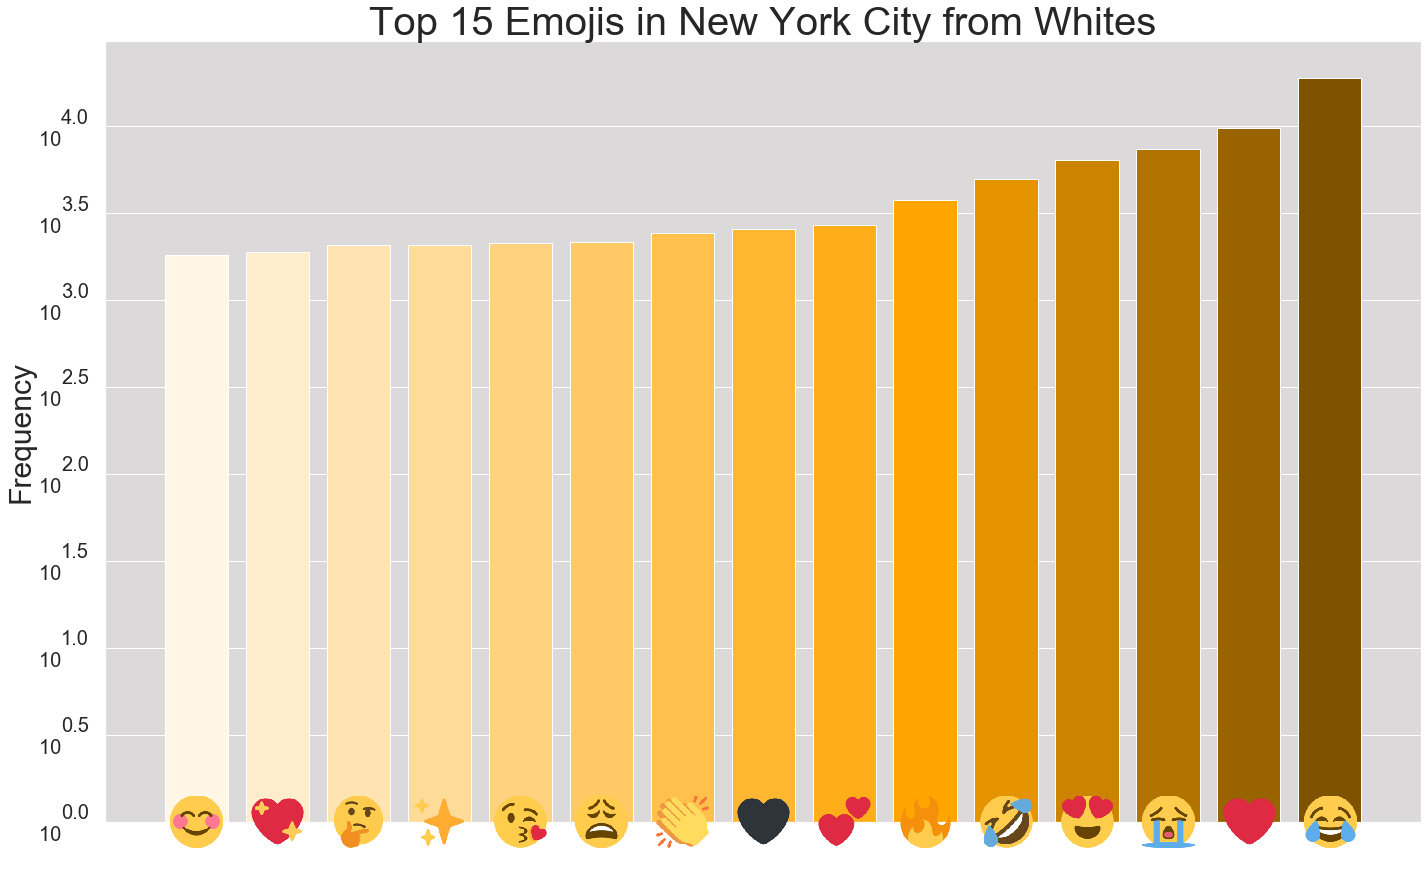

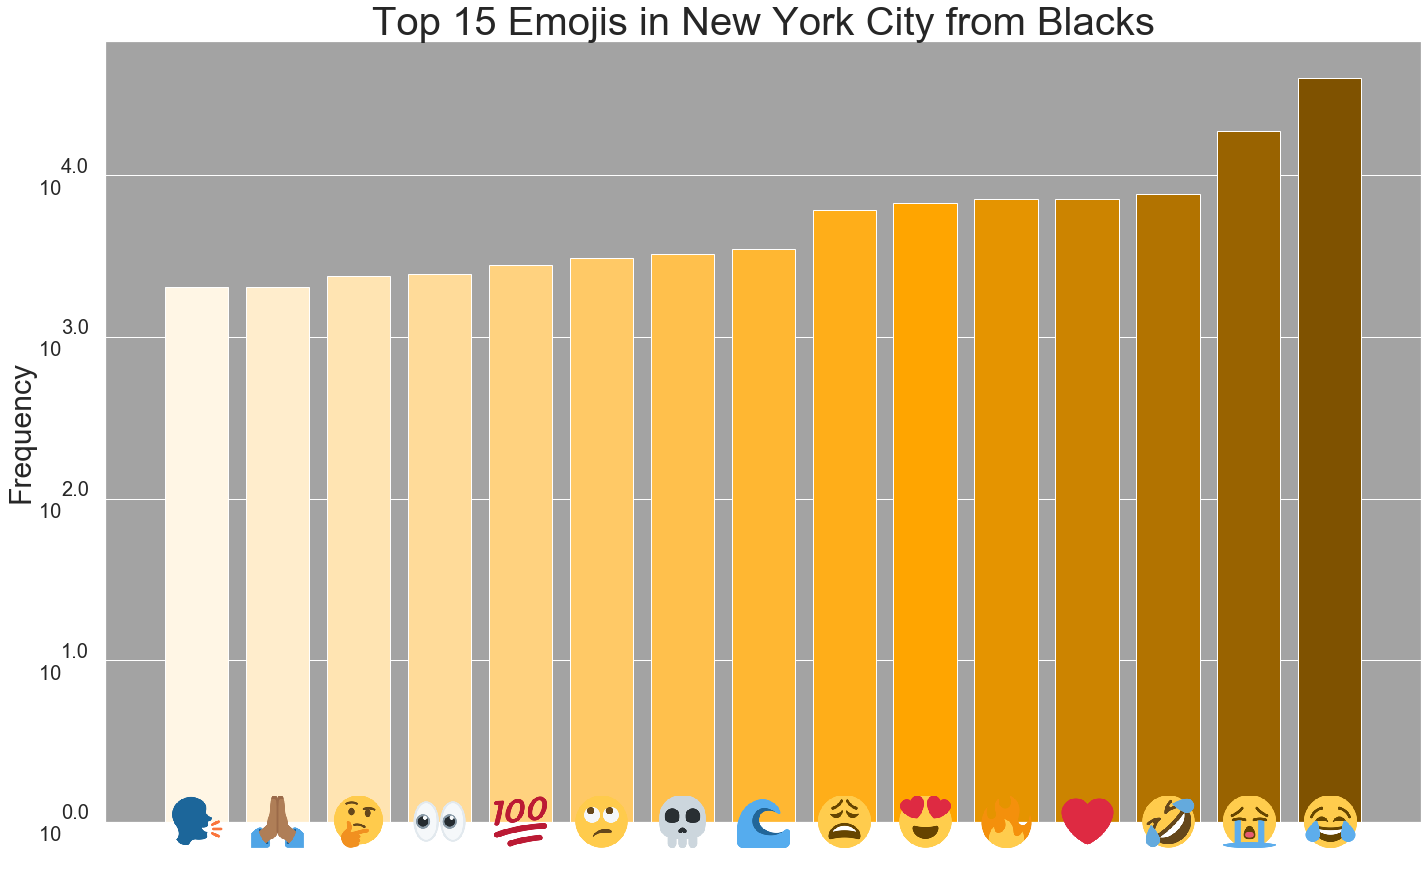

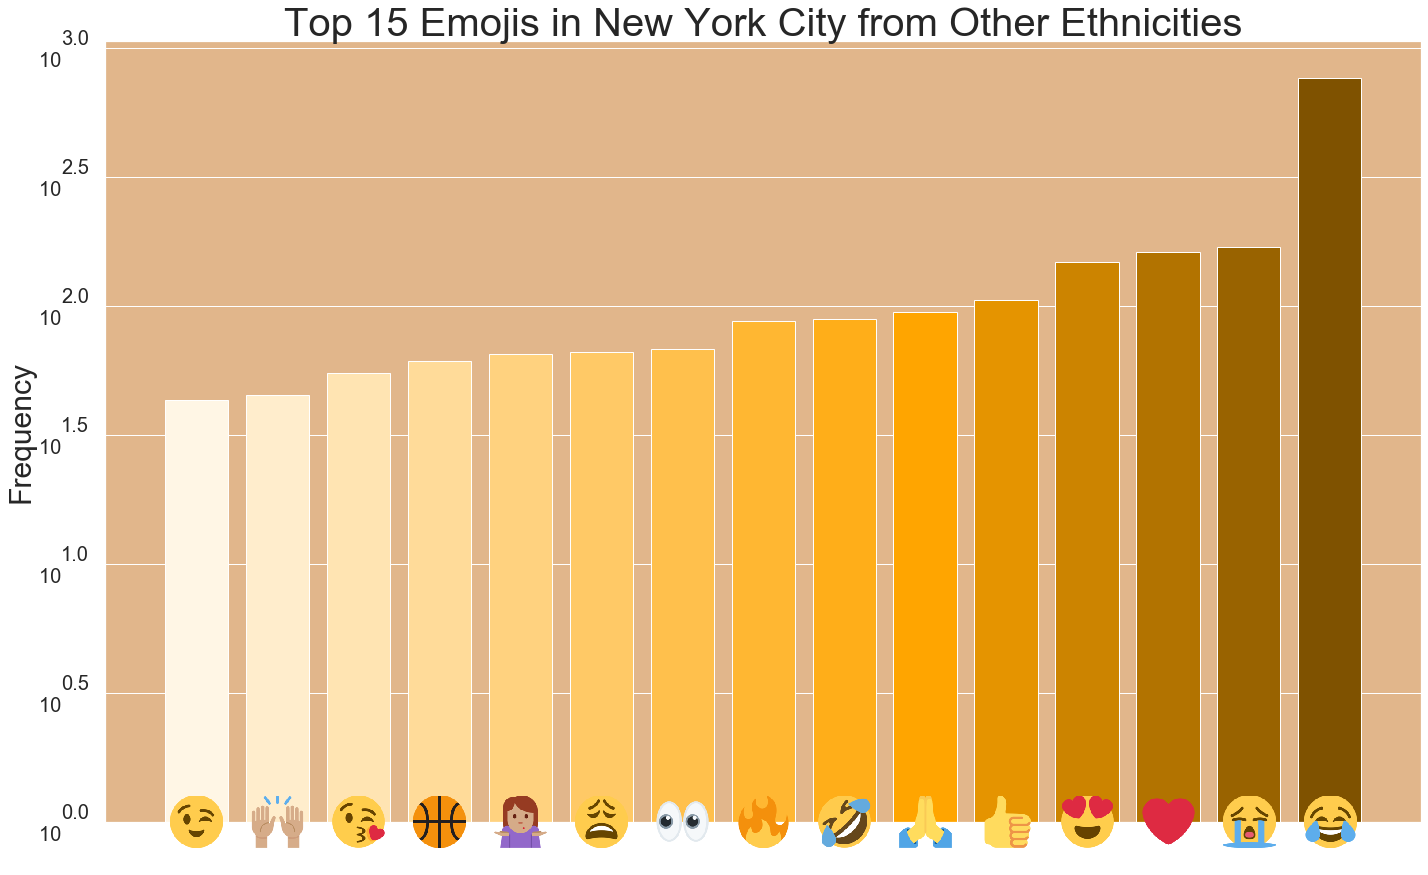

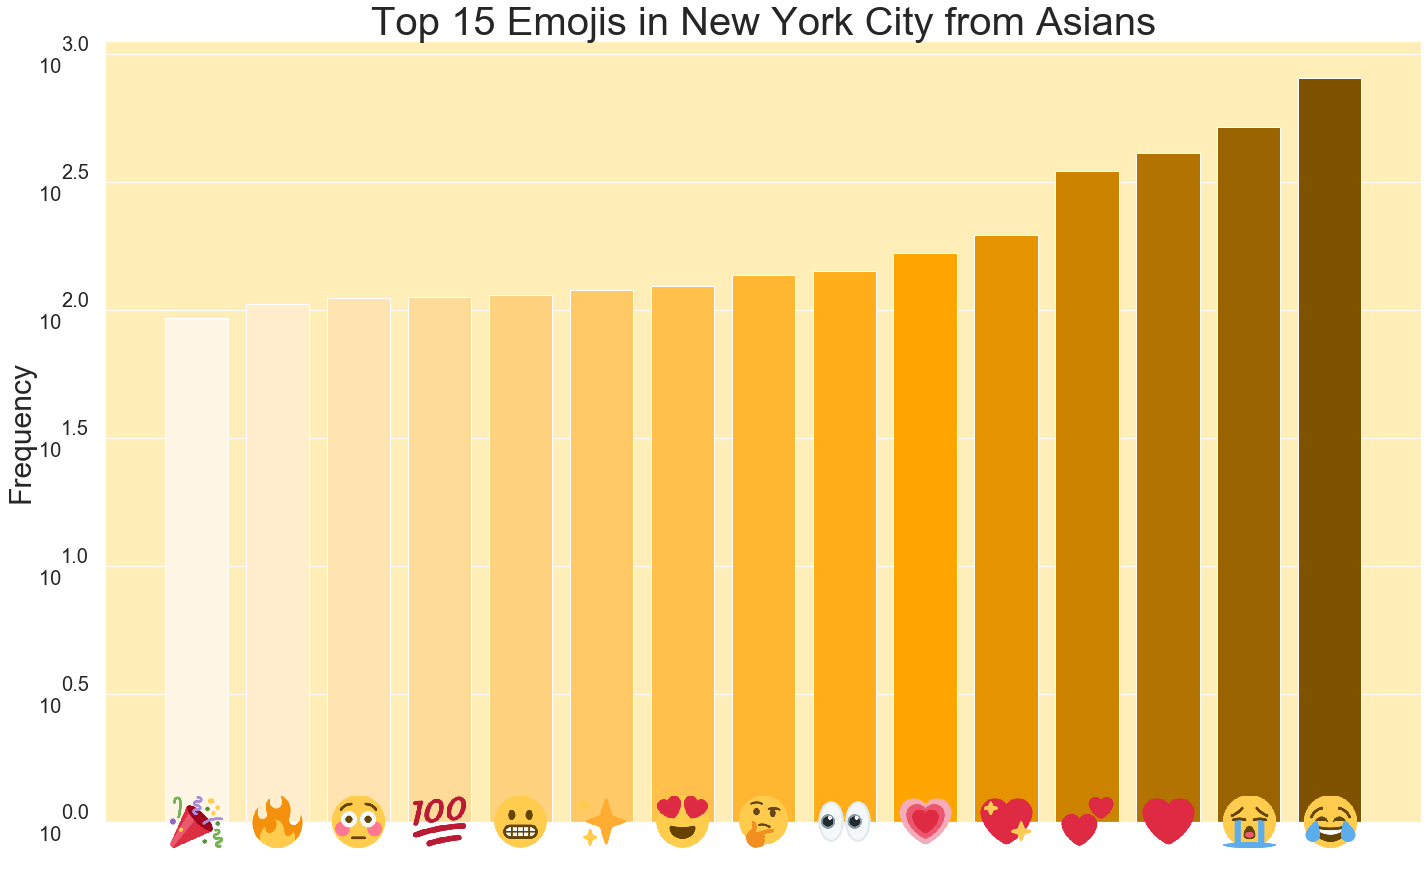

In [18]:
ethnicities_list = ['Whites','Blacks','Others','Asians']
ethnicities_values =[white_stats_df.sort_values(by=['Whites_Count']),black_stats_df.sort_values(by=['Blacks_Count']),other_stats_df.sort_values(by=['Others_Count']),asian_stats_df.sort_values(by=['Asians_Count'])]
ethnicities_graph_colours=['dbd9d9','a3a3a3','e1b68b','ffeeb7']

for ind,ethn in enumerate(ethnicities_list):

     # Top 15 Values
    x = ethnicities_values[ind]['Emoji'].tail(15).values
    y = ethnicities_values[ind]['{}_Count'.format(ethnicities_list[ind])].tail(15).values
    y_log = np.log10(y.astype(int))

    # Set linespacing
    x_linespace = linspace(0, 4*pi, num=15)

    # Plot Bar Chart
    fig, ax = plt.subplots(figsize=(20,12))
    ax.yaxis.set_major_formatter(formatter_pow10_1dp)
    ax.tick_params(axis='both', which='major', pad=10)
    ax.set_facecolor('#{}'.format(ethnicities_graph_colours[ind]))
    plt.grid(linestyle='-', linewidth=1,axis='y')
    plt.bar(x_linespace, y_log, width=0.7, bottom=None, align='center',color =colors_orange_fade)
    ax.get_xaxis().set_visible(False)
    plt.yticks(fontsize =20)
    plt.ylabel('Frequency', fontsize =30)
    plt.title('Top 15 Emojis in New York City from {}'.format(ethnicities_list[ind]), fontsize =40)
    if(ethnicities_list[ind] == 'Others'):
        plt.title('Top 15 Emojis in New York City from Other Ethnicities', fontsize =40)
    plt.tight_layout()

    # Plot emojis on x-axis
    bar_chart_plot_emojis(ax,fig,x)
    plt.show()

## Top 15 Dinstict Emojis Graph by Ethnicity

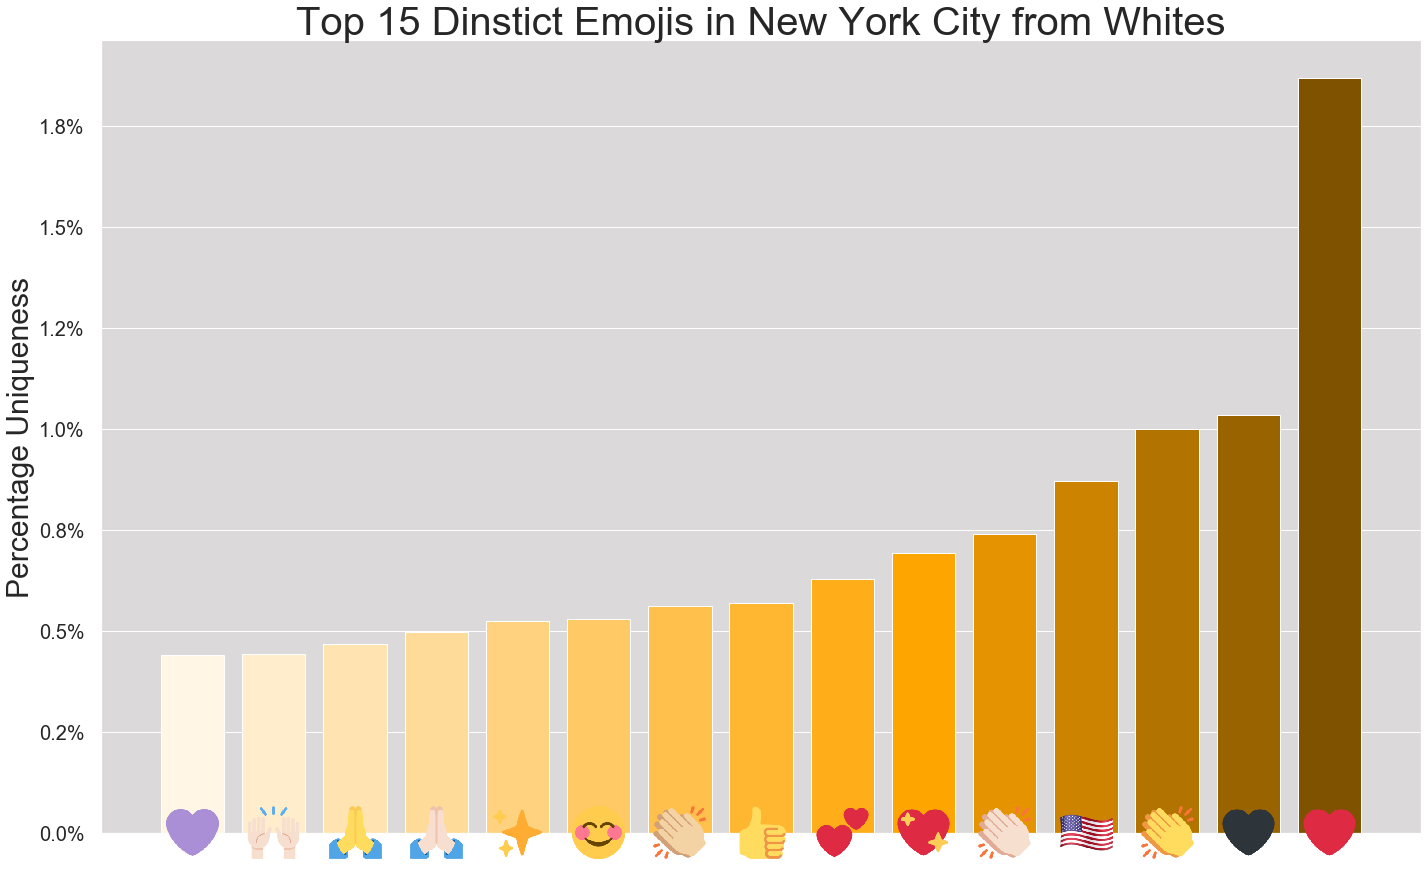

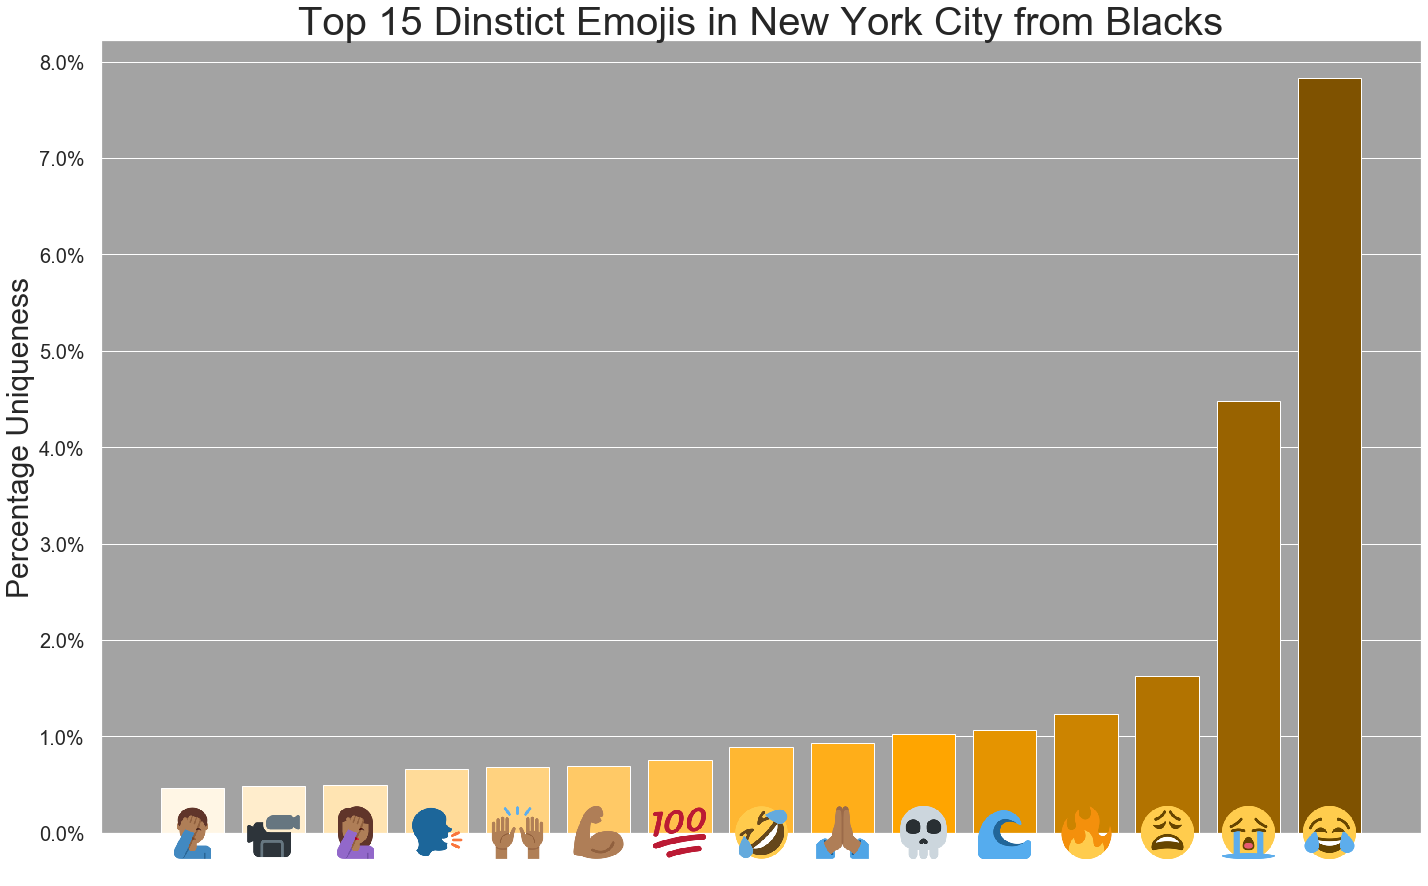

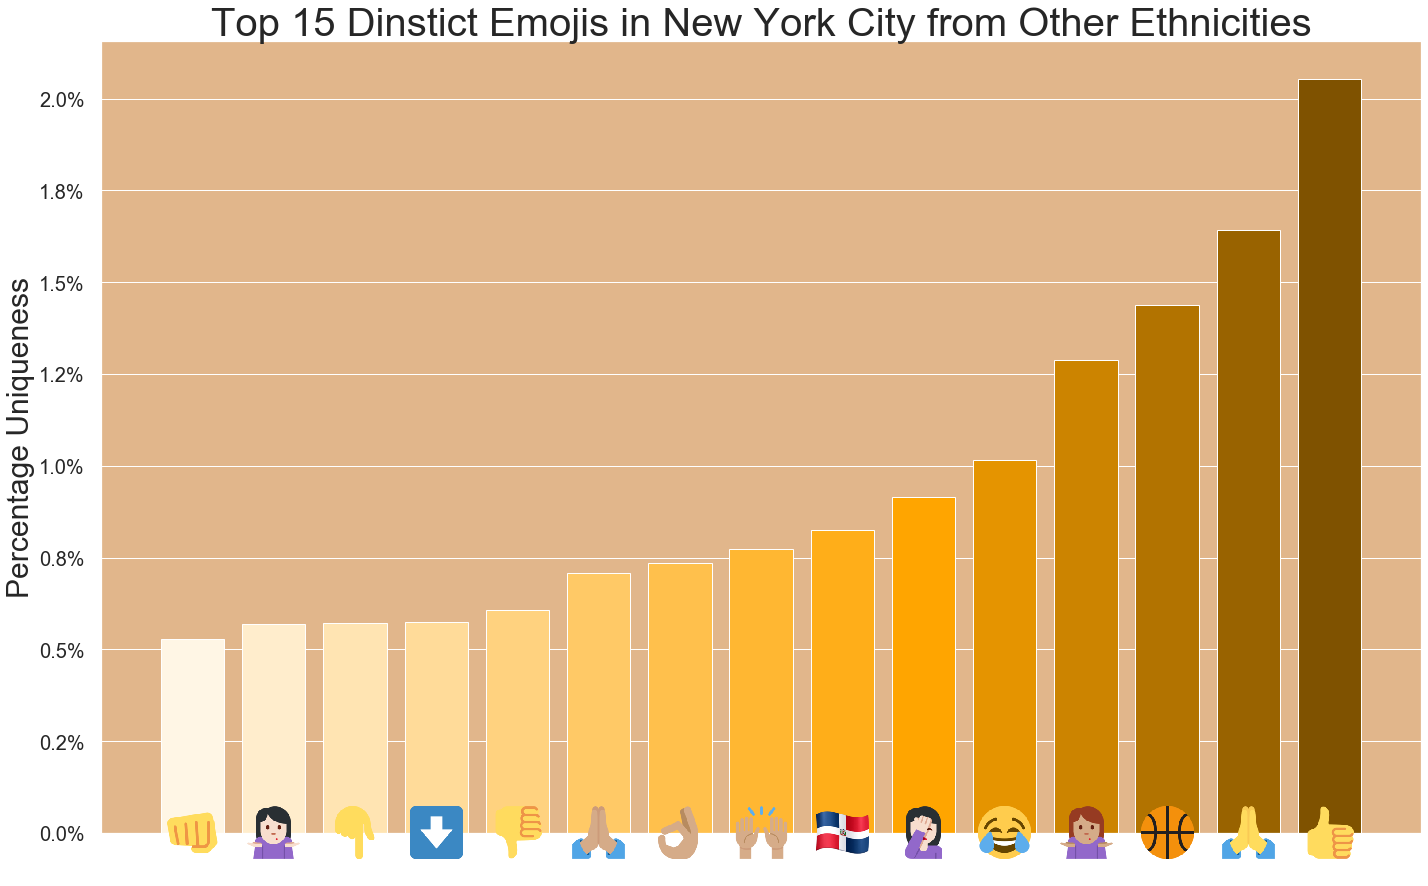

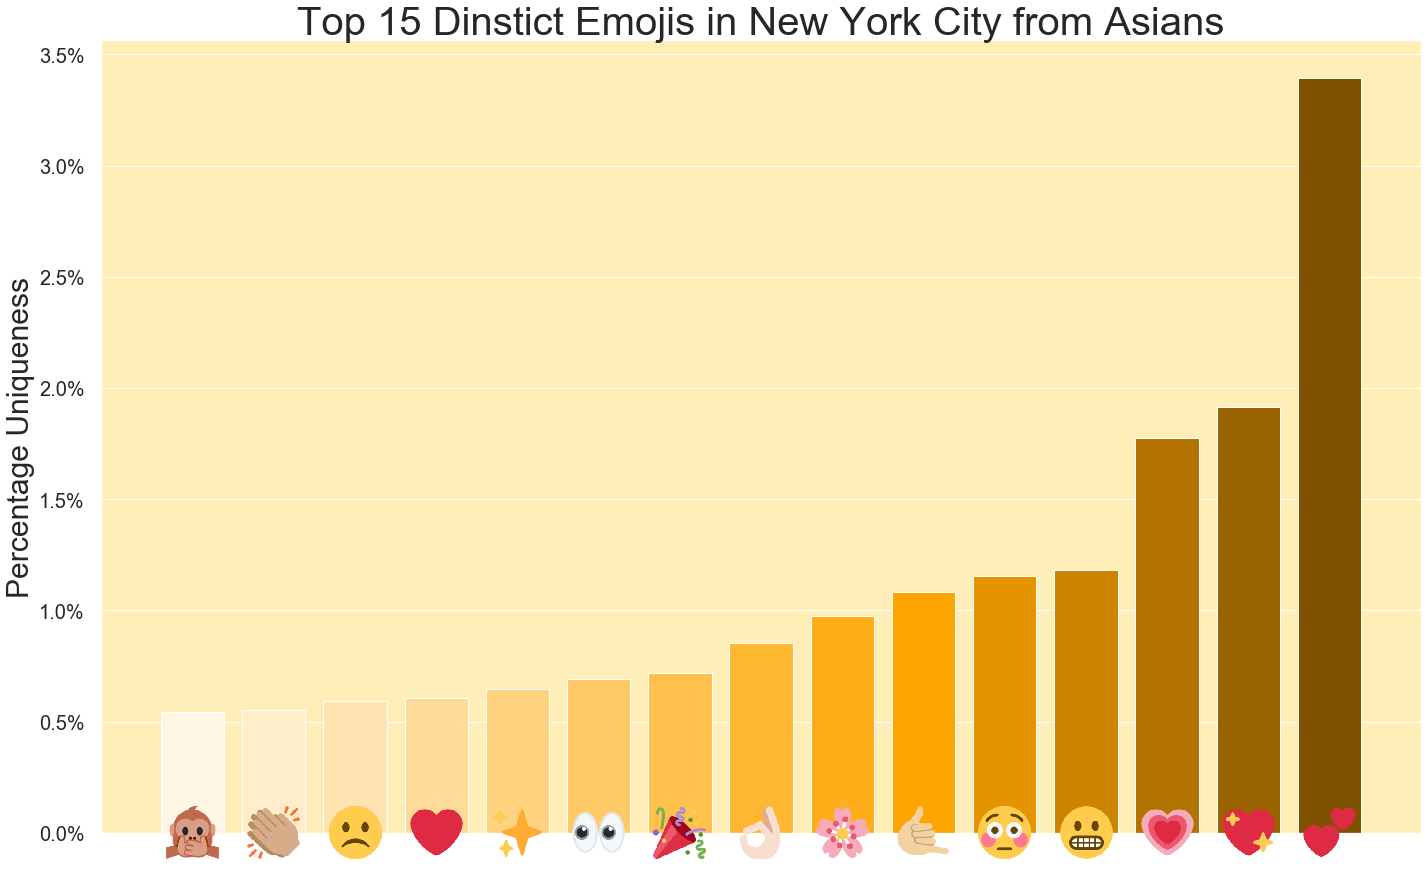

In [19]:
ethnicities_list = ['Whites','Blacks','Others','Asians']
ethnicities_values =[white_stats_df.sort_values(by=['Whites_Perc_Dif']),black_stats_df.sort_values(by=['Blacks_Perc_Dif']),other_stats_df.sort_values(by=['Others_Perc_Dif']),asian_stats_df.sort_values(by=['Asians_Perc_Dif'])]
ethnicities_graph_colours=['dbd9d9','a3a3a3','e1b68b','ffeeb7']

for ind,ethn in enumerate(ethnicities_list):

     # Top 15 Values
    x = ethnicities_values[ind]['Emoji'].tail(15).values
    y = ethnicities_values[ind]['{}_Perc_Dif'.format(ethnicities_list[ind])].tail(15).values

    # Set linespacing
    x_linespace = linspace(0, 4*pi, num=15)

    # Plot Bar Chart
    fig, ax = plt.subplots(figsize=(20,12))
    ax.yaxis.set_major_formatter(formatter_percentage)
    ax.tick_params(axis='both', which='major', pad=10)
    ax.set_facecolor('#{}'.format(ethnicities_graph_colours[ind]))
    plt.grid(linestyle='-', linewidth=1,axis='y')
    plt.bar(x_linespace, y, width=0.7, bottom=None, align='center',color =colors_orange_fade)
    ax.get_xaxis().set_visible(False)
    plt.yticks(fontsize =20)
    plt.ylabel('Percentage Uniqueness', fontsize =30)
    plt.title('Top 15 Dinstict Emojis in New York City from {}'.format(ethnicities_list[ind]), fontsize =40)
    if(ethnicities_list[ind] == 'Others'):
        plt.title('Top 15 Dinstict Emojis in New York City from Other Ethnicities', fontsize =40)
    plt.tight_layout()

    # Plot emojis on x-axis
    bar_chart_plot_emojis(ax,fig,x)
    plt.show()

## Top 15 Emojis in NYC Pie Chart

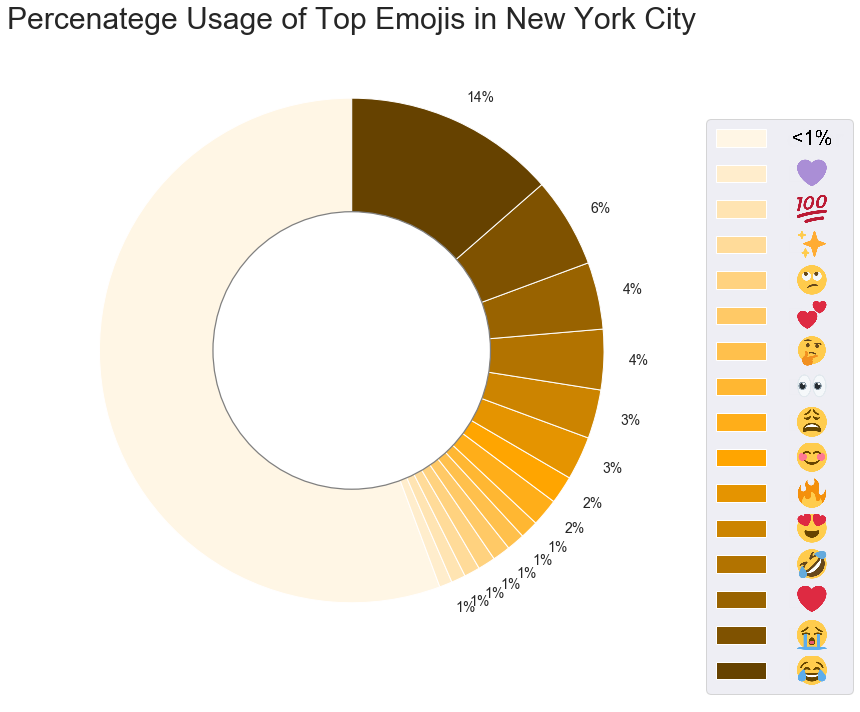

In [20]:
x = emojis_count_df['Emoji'].tail(15).values
y = (emojis_count_df['Count']/emojis_count_df['Count'].sum()).tail(15).values
fill = 1 -y.sum()
new_y = np.append([fill],y)

y_labels = []
for i,perc in enumerate (y):
    y_labels.append("{:.0f}%".format(perc*100))
# Don't show other <1%
y_labels.insert(0,"")

# Plot pie chart
fig, ax = plt.subplots(figsize=(17,12))
title = plt.title('Percenatege Usage of Top Emojis in New York City', fontsize =30)
title.set_ha("center")
plt.gca().axis("equal")
pie = plt.pie(new_y,labels=y_labels,colors=colors_orange_fade, startangle=90, textprops={'fontsize': 14})
legend = plt.legend(pie[0],np.append(['other'],x), bbox_to_anchor=(0.67,0.45), loc="center right", fontsize=25, 
           bbox_transform=plt.gcf().transFigure)
plt.setp(legend.get_texts(), color='#ededf3')
plt.subplots_adjust(left=0.0, bottom=0.15, right=0.5)

# Add cicrle in the center
centre_circle = plt.Circle((0,0),0.55,color='grey', fc='white',linewidth=1.25)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Plot emojis on legend
pie_chart_plot_emojis(ax,fig,x)
plt.show()